# Predicting the rating of a wine considering its variety and description

This notebook presents a neural network devised to predict the rating from a taster by considering as inputs their reviews and the wine variety. The code is based on the presented in https://github.com/sararob/keras-wine-model. However, with modifications: Keras is only used for pre-processing and TensorFlow is used to train and test the model. The architecture is also slightly different: L2 regularization and dropout are used and more processing units are used in the final layer of the network (after the concatenation prodecure), whilst the loss function used is cross-entropy instead of MSE, since we tackle the problem as a classification one. The ratings are in one-hot encoding format.

## Imports

In [2]:
%matplotlib nbagg
import csv, random, collections
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics       import mean_squared_error

## Auxiliary Functions

In [3]:
def iterate_minibatches(num_samples, batch_size, shuffle=False):
    batches_indices = []
    if shuffle:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
    for start_idx in range(0, num_samples - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx+batch_size]
        else:
            excerpt = slice(start_idx, start_idx+batch_size)
        yield excerpt

def shuffle_indices(num_samples):
    idx = np.arange(num_samples)
    np.random.shuffle(idx)
    return idx

## Load data

In [4]:
# We use one list for each column of the .csv
description   = []
variety       = []
rating        = []
filename = '../wine_data.csv' # You can find the dataset in: https://www.kaggle.com/zynicide/wine-reviews/data
with open(filename, 'rb') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    next(spamreader)
    for row in spamreader:
        if (row[5] != '') and (row[1] != ''):
            description.append(row[2])
            rating.append(row[4])
            variety.append(row[9])

# Remove all wine varieties that do not appear more than 500 times
# You can do this using pandas although here it is done in a more "low-level" manner
occurences = collections.Counter(variety)
to_remove = []
for key in occurences:
    if occurences[key] <= 500:
        to_remove.append(key)
for i in range(len(to_remove)):
    del occurences[to_remove[i]]

# Grab indices of varietyies that are not within occurences
to_remove = []
for i in range(len(variety)):
    if variety[i] not in occurences:
        to_remove.append(i)

# Actually delete the items from the lists
for i in sorted(to_remove, reverse=True):
    del variety[i]
    del description[i]
    del rating[i]

# Shufle lists
labels = []
new_variety = []
new_description = []
for i in shuffle_indices(num_samples=len(variety)):
    labels.append(rating[i]) # Or labels.append(price[i]) if we are going to classify prices 
    new_variety.append(variety[i])
    new_description.append(description[i])
variety = new_variety
description = new_description
del new_variety
del new_description
del rating

# Split data into train and test
train_size = int(len(variety) * .8)
print 'Dataset info: '
print "Train size: %d" % train_size
print "Test size: %d" % (len(variety) - train_size)

# Train
description_train = description[:train_size]
variety_train = variety[:train_size]
labels_train = labels[:train_size]

# Test
description_test = description[train_size:]
variety_test = variety[train_size:]
labels_test = labels[train_size:]

Dataset info: 
Train size: 95646
Test size: 23912


## Prepare data to feed it to the model

In [5]:
# Tokenize words
vocabulary_size = 10000

# Tokenize with KERAS
tokenize = keras.preprocessing.text.Tokenizer(num_words=vocabulary_size, char_level=False)
tokenize.fit_on_texts(description_train)

# ----------------------------- Bag of words ----------------------------- #
description_bow_train = tokenize.texts_to_matrix(description_train)
description_bow_test  = tokenize.texts_to_matrix(description_test)

# ----------------------------- Variety ----------------------------- #
# Use sklearn utility to convert label strings to numbered index
encoder         = LabelEncoder().fit(variety_train)
variety_train   = encoder.transform(variety_train).reshape((len(variety_train), 1))
variety_test    = encoder.transform(variety_test).reshape((len(variety_test), 1))
num_classes     = 1

# Convert variety to one hot
num_classes    += np.max(variety_train)
variety_train   = keras.utils.to_categorical(variety_train, num_classes)
variety_test    = keras.utils.to_categorical(variety_test, num_classes)

# ----------------------------- Embeddings ----------------------------- #
sequence_length = 150
embedding_size  = 10
train_embedding = tokenize.texts_to_sequences(description_train)
test_embedding  = tokenize.texts_to_sequences(description_test)

# Fill with zeros the sequences that are shorter than 150
train_embedding = keras.preprocessing.sequence.pad_sequences(train_embedding, maxlen=sequence_length, padding="post")
test_embedding  = keras.preprocessing.sequence.pad_sequences(test_embedding,  maxlen=sequence_length, padding="post")

# ----------------------------- Convert data to numpy arrays ----------------------------- #
variety_train           = np.asarray(variety_train)
variety_test            = np.asarray(variety_test)
description_bow_train   = np.asarray(description_bow_train)
description_bow_test    = np.asarray(description_bow_test)
train_embedding         = np.asarray(train_embedding)
test_embedding          = np.asarray(test_embedding)

# Convert labels to one-hot encoding
lb = LabelBinarizer()
lb.fit(range(101))
Y_train = lb.transform(labels_train)
Y_test  = lb.transform(labels_test)

## Define the model

In [6]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

# Auxiliary functions to create TF Variables
def embedding_variable(name, shape, minval, maxval):
    return tf.Variable(name=name, initial_value=tf.random_uniform(shape=shape, minval=minval, maxval=maxval))

def weight_variable(shape, name):
    return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape, name):
    return tf.Variable(tf.ones(shape), name=name)

# Actual model
def model(vocabulary_size, sequence_length, embedding_size, num_classes):
    # ----------------------- INPUT ----------------------- #
    with tf.name_scope('input'):
        x_description   = tf.placeholder(tf.float32, shape=[None, vocabulary_size], name='x_description')
        x_variety       = tf.placeholder(tf.float32, shape=[None, num_classes], name='x_variety')
        x_embedding     = tf.placeholder(tf.int32,   shape=[None, sequence_length], name='x_embedding')
        y_              = tf.placeholder(tf.float32, shape=[None, 101], name='y_')
        keep_prob       = tf.placeholder(tf.float32, name='keep_prob')
    
    # ----------------------- NET 1 (EMBEDDING) ----------------------- #
    with tf.name_scope('net1'):
        with tf.name_scope('net1_embedding_layer'):
            W_embeddings = embedding_variable(shape=[vocabulary_size, embedding_size], name="W_embeddings", minval=-1.0, maxval=1.0)
            lookup       = tf.nn.embedding_lookup(W_embeddings, x_embedding)
            embed        = tf.reshape(lookup, [-1, embedding_size*sequence_length]) # Flatten lookup
        with tf.name_scope('net1_out'):
            input_size   = embedding_size*sequence_length
            output_size  = 100
            W_net1       = weight_variable(shape=[input_size, output_size], name='W_net1')
            b_net1       = bias_variable(shape=[output_size], name='b_net1')
            h_net1       = tf.matmul(embed, W_net1) + b_net1
            
    # ----------------------- NET 2 (BOW FOR DESCRIPTION + ONE-HOT FOR VARIETY) ----------------------- #
    with tf.name_scope('net2'):
        with tf.name_scope('net2_fc1'):
            x_net1      = tf.concat([x_description, x_variety], axis=1)
            input_size  = x_net1.get_shape().as_list()[1]
            output_size = 256
            W_net2_fc1  = weight_variable(shape=[input_size, output_size], name='W_net2_fc1')
            b_net2_fc1  = bias_variable(shape=[output_size], name='b_net2_fc1')
            h_net2_fc1  = tf.nn.relu(tf.matmul(x_net1, W_net2_fc1) + b_net2_fc1)
            h_net2_fc1  = tf.nn.dropout(h_net2_fc1, keep_prob=keep_prob)
        with tf.name_scope('net2_out'):
            input_size  = output_size
            output_size = 100
            W_net2      = weight_variable(shape=[input_size, output_size], name='W_net2')
            b_net2      = bias_variable(shape=[output_size], name='b_net2')
            h_net2      = tf.matmul(h_net2_fc1, W_net2) + b_net2
    
    # ----------------------- MERGE OUTPUTS OF NET1 AND NET2 ----------------------- #
    with tf.name_scope('merge_nets'):
        x           = tf.concat([h_net1, h_net2], axis=1)
        input_size  = h_net1.get_shape().as_list()[1] + h_net2.get_shape().as_list()[1]
        output_size = 101
        W           = weight_variable(shape=[input_size, output_size], name='W')
        b           = bias_variable(shape=[output_size], name='b')
        y           = tf.matmul(x, W) + b
        scores      = tf.nn.softmax(y)

    # ----------------------- LOSS FUNCTION ----------------------- #
    with tf.name_scope('l2_loss'):
        l2_loss = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables() if 'W' in v.name]) * 0.001
    
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)) + l2_loss

    # ----------------------- RETURN DICTIONARY ----------------------- #
    return {
            'x_description':    x_description,
            'x_variety':        x_variety,
            'x_embedding':      x_embedding,
            'x':                x,
            'y_':               y_,
            'keep_prob':        keep_prob,
            'loss':             loss,
            'scores':           scores}

with tf.device('/gpu:0'):
    net = model(vocabulary_size=vocabulary_size, sequence_length=sequence_length, embedding_size=embedding_size, num_classes=num_classes)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(net['loss'])

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Train model

In [7]:
# Init variables
sess.run(tf.global_variables_initializer())

# Train the network
epochs       = 100
batch_size   = 128

# For plotting the losses
p_train_loss = []
p_test_loss  = []
print '\nTraining Network...'
for epoch in range(epochs):
    train_loss    = 0.0
    train_batches = 0.0
    train_mse     = 0.0
    for indices in iterate_minibatches(num_samples=Y_train.shape[0], batch_size=batch_size, shuffle=True):
        y_            = Y_train[indices,:]
        x_description = description_bow_train[indices,:]
        x_variety     = variety_train[indices,:]
        x_embedding   = train_embedding[indices,:]
        sess.run(optimizer, feed_dict={ net['x_description']: x_description,
                                        net['x_variety']:     x_variety,
                                        net['x_embedding']:   x_embedding,
                                        net['y_']:            y_,
                                        net['keep_prob']:     0.5})
        pred, loss = sess.run([net['scores'], 
                               net['loss']],
                               feed_dict={net['x_description']: x_description,
                                          net['x_variety']:     x_variety,
                                          net['x_embedding']:   x_embedding,
                                          net['y_']:            y_,
                                          net['keep_prob']:     1.0})
        train_loss      += loss
        train_mse       += mean_squared_error(np.argmax(y_, axis=1), np.argmax(pred, axis=1))
        train_batches   += 1.0
    train_loss = train_loss / train_batches
    train_mse  = train_mse / train_batches
    # Test
    test_loss    = 0.0
    test_batches = 0.0
    test_mse     = 0.0
    for indices in iterate_minibatches(num_samples=Y_test.shape[0], batch_size=batch_size, shuffle=False):
        y_= Y_test[indices,:]
        x_description    = description_bow_test[indices,:]
        x_variety        = variety_test[indices,:]
        x_embedding      = test_embedding[indices,:]
        feed_dict        = {net['x_description']: x_description, 
                            net['x_variety']:     x_variety, 
                            net['x_embedding']:   x_embedding, 
                            net['y_']:            y_, 
                            net['keep_prob']:     1.0}
        pred, loss       = sess.run([net['scores'], net['loss']], feed_dict=feed_dict)
        test_loss       += loss
        test_mse        += mean_squared_error(np.argmax(y_, axis=1), np.argmax(pred, axis=1))
        test_batches    += 1.0
    test_loss = test_loss / test_batches
    test_mse  = test_mse / test_batches
    # For the plot
    p_train_loss.append(train_loss)
    p_test_loss.append(test_loss)
    # Print losses each 10 epochs
    if (epoch % 10 == 0): 
        print '\nEpoch %d/%d' % (epoch+1, epochs)
        print 'Train loss: ', train_loss
        print 'Test loss: ', test_loss
        print 'Train MSE: ', train_mse
        print 'Test MSE: ', test_mse
        


Training Network...

Epoch 1/100
Train loss:  3.719155812359239
Test loss:  2.7373269860462477
Train MSE:  7.554969879518072
Test MSE:  7.178259408602151

Epoch 11/100
Train loss:  2.136696351420289
Test loss:  2.2075398352838334
Train MSE:  6.111539909638554
Test MSE:  6.581359206989247

Epoch 21/100
Train loss:  2.0958176516146065
Test loss:  2.1671837235009797
Train MSE:  6.105003346720214
Test MSE:  6.540112567204301

Epoch 31/100
Train loss:  2.097976459716378
Test loss:  2.1794783761424403
Train MSE:  6.128650016733601
Test MSE:  6.983366935483871

Epoch 41/100
Train loss:  2.097583308117776
Test loss:  2.1678501188114123
Train MSE:  6.129329819277109
Test MSE:  6.732190860215054

Epoch 51/100
Train loss:  2.095266655267003
Test loss:  2.1627769149759764
Train MSE:  6.115325886880857
Test MSE:  6.56804435483871

Epoch 61/100
Train loss:  2.098294240882598
Test loss:  2.159907894749795
Train MSE:  6.126526941097724
Test MSE:  6.653897849462366

Epoch 71/100
Train loss:  2.0972243

## Plot loss

<IPython.core.display.Javascript object>


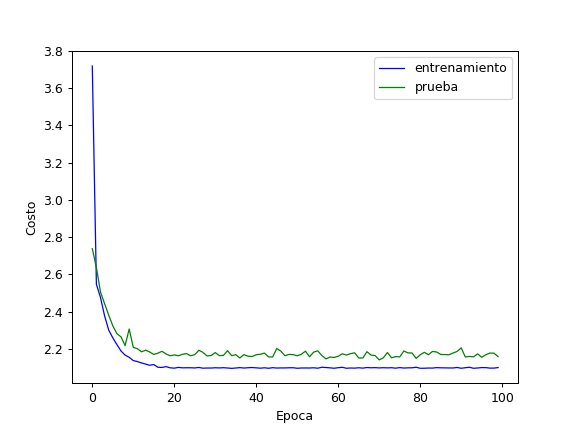

In [20]:
p1, = plt.plot(np.arange(100), p_train_loss, linewidth=1, color='b', label="entrenamiento")
p2, = plt.plot(np.arange(100), p_test_loss, linewidth=1, color='g', label="prueba")
plt.xlabel('Epoca')
plt.ylabel('Costo')
plt.legend([p1, p2], ["entrenamiento", "prueba"])
plt.savefig('losses.png', dpi=200)

## Test model

In [14]:
print '\nTesting Network...'
test_loss    = 0.0
test_batches = 0.0
mse          = 0.0
for indices in iterate_minibatches(num_samples=Y_test.shape[0], batch_size=batch_size, shuffle=False):
    y_= Y_test[indices,:]
    x_description    = description_bow_test[indices,:]
    x_variety        = variety_test[indices,:]
    x_embedding      = test_embedding[indices,:]
    feed_dict        = {net['x_description']: x_description, 
                        net['x_variety']:     x_variety, 
                        net['x_embedding']:   x_embedding, 
                        net['y_']:            y_, 
                        net['keep_prob']:     1.0}
    pred, loss       = sess.run([net['scores'], net['loss']], feed_dict=feed_dict)
    test_loss       += loss
    mse             += mean_squared_error(np.argmax(y_, axis=1), np.argmax(pred, axis=1))
    test_batches    += 1.0
test_loss = test_loss / test_batches
mse       = mse / test_batches
print '\nLoss for the test set: ', test_loss
print 'MSE for the test set: ', mse

# Predict for num_samples wines from the test set
idx = shuffle_indices(Y_test.shape[0])
num_samples = 5
idx = idx[0:num_samples]
y_               = Y_test[idx,:]
x_description    = description_bow_test[idx,:]
x_variety        = variety_test[idx,:]
x_embedding      = test_embedding[idx,:]
feed_dict        = {net['x_description']: x_description, 
                    net['x_variety']:     x_variety, 
                    net['x_embedding']:   x_embedding, 
                    net['y_']:            y_, 
                    net['keep_prob']:     1.0}
loss, prediction = sess.run([net['loss'], net['scores']], feed_dict=feed_dict)

print '\nLoss for the first 5 test samples: ', loss
for i in range(num_samples):
    print description_test[i]
    print 'Actual: ', np.argmax(y_[i,:]), ' Predicted: ', np.argmax(prediction[i,:]), '\n'


Testing Network...

Loss for the test set:  2.157536515625574
MSE for the test set:  6.768607190860215

Loss for the first 5 test samples:  2.056796
An everyday Zin, soft and candied, with blackberry, cherry, licorice and cocoa flavors. The tannin structure is rich. Drink now.
Actual:  91  Predicted:  92 

Forward and immediately delicious, this has a mix of peach, pear, apple and the more expected red fruits; it's a wild panoply of fruit flavor, with balancing acids and tannins. Round, forward, full bodied and textural, it is a uniquely flavorful wine with distinctive fruit-laden profile.
Actual:  92  Predicted:  92 

Zelma Long's tradition of excellence continues with the Series M: Its deep chocolate, cinnamon and berry aromas and full, complex waves of delicious fruit and spice are exactly what a Bordeaux blend should be. Restrained but memorable, the wine has firm structure and will age beautifully.
Actual:  83  Predicted:  85 

Lots of astringent tannins in this dry, young blend 